In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
import chess_stats as cs

In [4]:
df = cs.game_stats_df('johnstelmach')

In [5]:
df.set_index(['end_time'], inplace=True)

In [6]:
df = df[(df['rules'] == 'chess') & (df['time_class'] == 'blitz')]

In [7]:
ts_hourly_df = df.resample('D').mean()['player_rating'].fillna(method='ffill')

In [11]:
ts_hourly_df.head()

end_time
2015-06-16    967.000000
2015-06-17    818.578947
2015-06-18    799.470588
2015-06-19    751.222222
2015-06-20    744.500000
Freq: D, Name: player_rating, dtype: float64

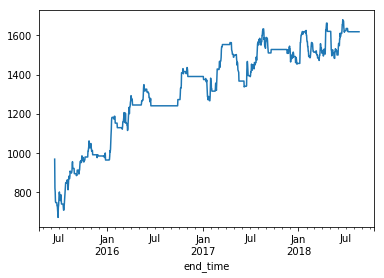

In [12]:
ts_hourly_df.plot()

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [14]:
sm.tsa.stattools.adfuller(ts_hourly_df)

(-2.206059181361809,
 0.20405367829702942,
 7,
 1154,
 {'1%': -3.436029294258502,
  '10%': -2.5681052115616243,
  '5%': -2.864047798131664},
 8911.44508425554)

In [17]:
sm.graphics.plot

AttributeError: module 'statsmodels.graphics.api' has no attribute 'plot_acf'

In [37]:
model = SARIMAX(ts_hourly_df, order = (3, 1, 2), seasonal_order=(1,0,0,52))

NotImplementedError: 

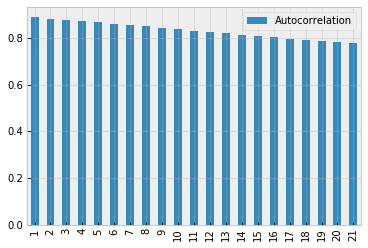

In [112]:
acf_1 = acf(rating)[20:400]
test_df = pd.DataFrame([acf_1]).T
test_df.columns = ['Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar');

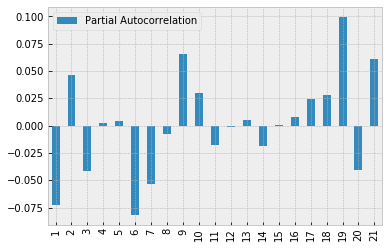

In [113]:
pacf_1 = pacf(ln_rating)[20:300]
test_df = pd.DataFrame([pacf_1]).T
test_df.columns = ['Partial Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')

In [114]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
import scipy.stats as scs

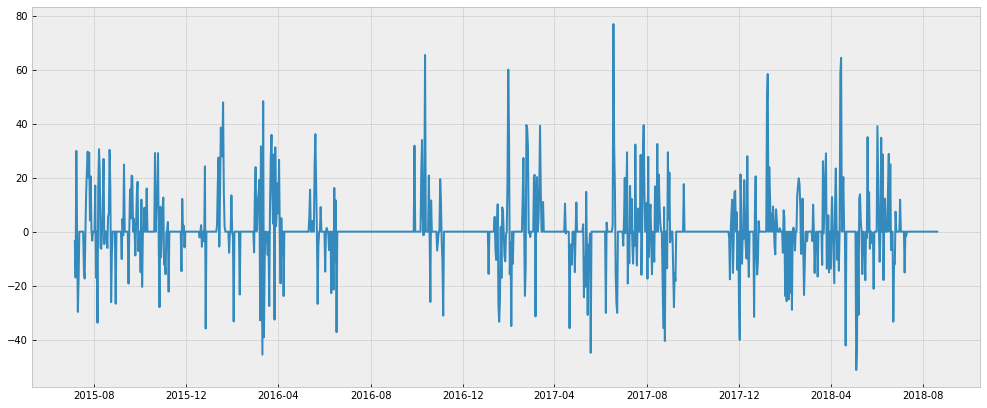

In [115]:
fig, ax = plt.subplots(figsize=(17, 7))

ax.plot(ts_hourly_df[20:].diff())

In [31]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [39]:
ts_hourly_df

end_time
2015-06-16     967.000000
2015-06-17     818.578947
2015-06-18     799.470588
2015-06-19     751.222222
2015-06-20     744.500000
2015-06-21     744.500000
2015-06-22     744.500000
2015-06-23     744.500000
2015-06-24     744.500000
2015-06-25     729.500000
2015-06-26     729.500000
2015-06-27     712.166667
2015-06-28     690.454545
2015-06-29     668.785714
2015-06-30     720.333333
2015-07-01     731.000000
2015-07-02     754.500000
2015-07-03     791.230769
2015-07-04     799.000000
2015-07-05     785.882353
2015-07-06     775.333333
2015-07-07     771.857143
2015-07-08     754.833333
2015-07-09     784.764706
2015-07-10     784.764706
2015-07-11     755.000000
2015-07-12     737.250000
2015-07-13     737.250000
2015-07-14     737.250000
2015-07-15     737.250000
                 ...     
2018-07-22    1619.000000
2018-07-23    1619.000000
2018-07-24    1619.000000
2018-07-25    1619.000000
2018-07-26    1619.000000
2018-07-27    1619.000000
2018-07-28    1619.000000
201

In [34]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ts_hourly_df, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

aic:    inf | order: None


AttributeError: 'NoneType' object has no attribute 'resid'

In [35]:
n_steps = 100

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(ts_hourly_df.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

AttributeError: 'NoneType' object has no attribute 'forecast'

NameError: name 'best_mdl' is not defined

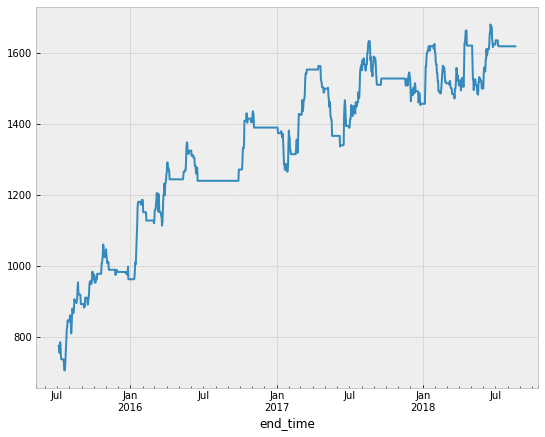

In [22]:
plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = ts_hourly_df.iloc[20:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[1], ts.index[100])
pred.plot(ax=ax, style='r-', label='In-sample prediction')
ax.plot(fc_all['forecast'])

AttributeError: 'NoneType' object has no attribute 'plot_predict'

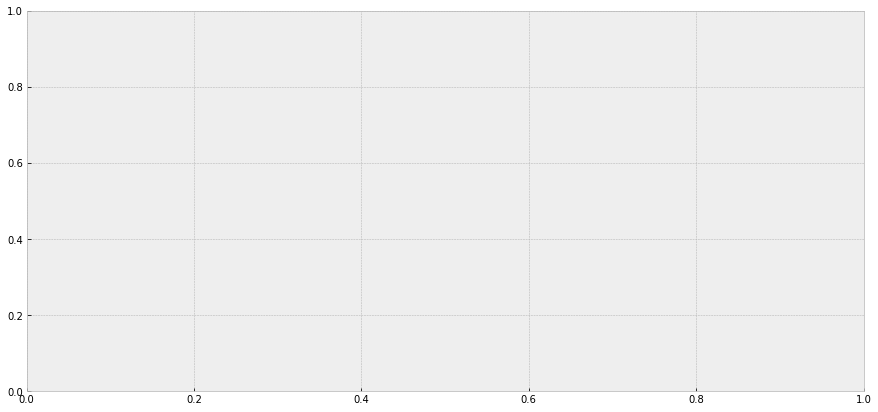

In [28]:
fig, ax = plt.subplots(figsize= (15, 7))
best_mdl.plot_predict(alpha=.5, ax=ax)
ax.set_xlim()